In [1]:
import sjldpm
from sjldpm.apps.cond.try_cond_1 import *
import importlib
importlib.reload(sjldpm.apps.cond.try_cond_1)

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from skimage.transform import rescale, resize

2024-10-18 18:22:05.363366: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
Using TensorFlow backend.


In [2]:
from sjldpm.apps.reference.ddpm2_h import imread,list_pictures

In [3]:
def show_image(path,scale=1):
    img = mpimg.imread(path)
    if scale<1:
        img = rescale(img,scale)
    imgplot = plt.imshow(img)
    plt.show()

def show_image2(path1,path2):
    img1 = mpimg.imread(path1)
    img2 = mpimg.imread(path2)
    fig,axes= plt.subplots(1,2)
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    plt.show()

def to_displayable_img(img):
    return cv2.cvtColor( (img/2+0.5).astype(np.float32), cv2.COLOR_BGR2RGB)


In [4]:
gpuid = 1
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpuid}"
log_dir = use_log_dir(sjldpm,cfn,"loadPretrained",10)
# ------------------

config  = get_config()
print(" Create model ...")
model = call_by_inspect( get_model, config)
print(" ... Load weights ...")
path_ckpt = Path("/home/yumeng/workspace/DDPM-SuJL/Results-old/ddpm2__v2/version_1/weights/model.weights").as_posix()
model.load_weights(path_ckpt)

 Create model ...



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       128000      input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 3456        input_1[0][0]                    
____________________________________________________________________________________________

2024-10-18 18:22:10.315079: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2024-10-18 18:22:10.348557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:5e:00.0
2024-10-18 18:22:10.348604: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-10-18 18:22:10.378697: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-10-18 18:22:10.380625: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2024-10-18 18:22:10.381356: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcurand.so.10
2024-10-18 18:22:10.385051: I tensorflow/stream_executor/platform/d

In [5]:
def sample_ddim_partial(model, path=None, B=1, z_samples=None, stride=1, eta=1,stop_last_n =1,*,img_size,bar_alpha):
    bar_alpha_ = bar_alpha[::stride]
    bar_alpha_pre_ = np.pad(bar_alpha_[:-1], [1, 0], constant_values=1)
    bar_beta_ = np.sqrt(1 - bar_alpha_**2)
    bar_beta_pre_ = np.sqrt(1 - bar_alpha_pre_**2)
    alpha_ = bar_alpha_ / bar_alpha_pre_
    sigma_ = bar_beta_pre_ / bar_beta_ * np.sqrt(1 - alpha_**2) * eta
    epsilon_ = bar_beta_ - alpha_ * np.sqrt(bar_beta_pre_**2 - sigma_**2)
    T_ = len(bar_alpha_)
    # 采样过程
    if z_samples is None:
        z_samples = np.random.randn(B, img_size, img_size, 3) # Noise
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(T_ - stop_last_n), ncols=0):
        t = T_ - t - 1
        bt = np.array([[t * stride]] * z_samples.shape[0])
        # z_samples = cond_fn(z_samples,bt,bar_beta_)
        z_samples -= epsilon_[t] * model.predict([z_samples, bt])
        z_samples /= alpha_[t]
        z_samples += np.random.randn(*z_samples.shape) * sigma_[t]
        
    
    h,w = z_samples.shape[1],z_samples.shape[2]
    upz_samples = np.zeros((4*B,img_size,img_size,3))
    for i in range(4):
        upz_samples[i*B:i*B+B,:,:,:] = z_samples
    
    
    # Do the rest of steps
    for t in tqdm(range(T_ - stop_last_n,T_), ncols=0):
        t = T_ - t  - 1
        bt = np.array([[t * stride]] * upz_samples.shape[0])
        # z_samples = cond_fn(z_samples,bt,bar_beta_)
        upz_samples -= epsilon_[t] * model.predict([upz_samples, bt])
        upz_samples /= alpha_[t]
        upz_samples += np.random.randn(*upz_samples.shape) * sigma_[t]
    
    fsz_samples = np.zeros((B,h*2,w*2,3))
    for ix in range(2):
        for iy in range(2):
            for j in range(B):
                # fsz_samples[j,ix:h*2:2,iy:w*2:2,:] = upz_samples[j*B+ix +iy,:,:,:]
                fsz_samples[j,ix:h*2:2,iy:w*2:2,:] = upz_samples[i*B+j,:,:,:]
    
    
    x_samples = np.clip(fsz_samples, -1, 1)
    fsimg_size= img_size *2
    if path is None:
        return x_samples
    figure = np.zeros((fsimg_size * B, fsimg_size * B, 3))
    for i in range(B):
        for j in range(B):
            digit = x_samples[i * B+ j]
            figure[i * fsimg_size:(i + 1) * fsimg_size,
                   j * fsimg_size:(j + 1) * fsimg_size] = digit
    imwrite(path, figure)
    
    xsx_samples = np.clip(upz_samples, -1, 1)
    xsB = 2*B
    xspath = Path(Path(path).parent,Path(path).stem+"_sub.png")
    if xspath is None:
        return xsx_samples
    xsfigure = np.zeros((img_size * xsB, img_size * xsB, 3))
    for i in range(xsB):
        for j in range(xsB):
            digit = xsx_samples[i * B+ j]
            xsfigure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(xspath, xsfigure)
    return (figure,xsfigure),(path, xspath)
    

100% 35/35 [00:00<00:00, 35.40it/s]
100% 15/15 [00:00<00:00, 17.33it/s]


Imwrite ...

Imwrite ...

/home/yumeng/workspace/DDPM-SuJL/Results/sjldpm-try_cond_1__loadPretrained/version_10/upx_1.png


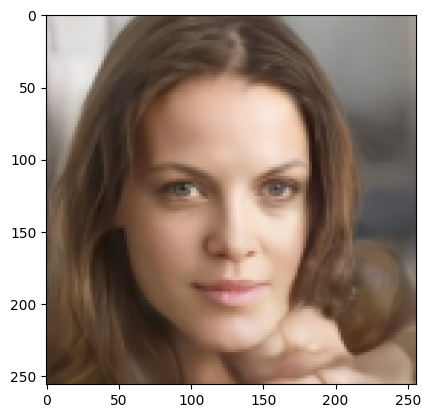

/home/yumeng/workspace/DDPM-SuJL/Results/sjldpm-try_cond_1__loadPretrained/version_10/upx_1_sub.png


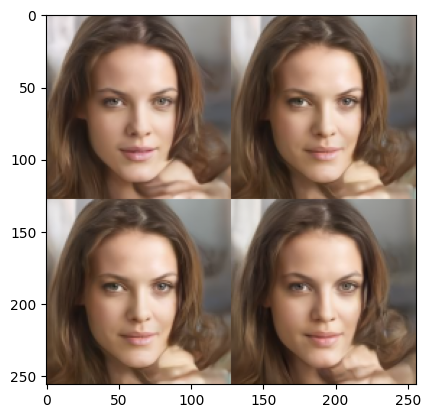

In [10]:
p1 = Path(log_dir,"upx_1.png").as_posix()
(figure,xsfigure),(path, xspath)= sample_ddim_partial(model, p1, B=1, z_samples=None, stride=20, eta=0.8,stop_last_n =15,img_size=config["img_size"],bar_alpha=config["bar_alpha"])
print(path)
show_image(path) 
print(xspath)
show_image(xspath)

In [7]:
import numpy as np
a = np.array(list(range(24)))
b = np.array(list(range(24)))

print(a[0:24:2])

b[0:24:2] =- a[0:24:2]
print(b)

[ 0  2  4  6  8 10 12 14 16 18 20 22]
[  0   1  -2   3  -4   5  -6   7  -8   9 -10  11 -12  13 -14  15 -16  17
 -18  19 -20  21 -22  23]
